In [84]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier

import shap


In [98]:
fname = 'data/dry_eye_disease_sleep_disorder_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'

In [99]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

# #Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic', 'combined_condition'] #,\
#              'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
#                  'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'combined_condition']


In [100]:
df.columns

Index(['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level',
       'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight',
       'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day',
       'caffeine_consumption', 'alcohol_consumption', 'smoking',
       'medical_issue', 'ongoing_medication', 'smart_device_before_bed',
       'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain',
       'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease',
       'bp_category'],
      dtype='object')

In [101]:
def feature_selection(df, col, best_params=None):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    # Splitting into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    if best_params== None:
        # Define XGBoost model
        xgb_model = xgb.XGBClassifier(objective='reg:squarederror', random_state=42)

        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.7, 0.8, 1.0],
            'colsample_bytree': [0.7, 0.8, 1.0]
            #,'lambda': [1, 3, 5, 7, 9]
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    #best_xgb = xgb.XGBClassifier(**best_params, objective='reg:squarederror', random_state=42)
    best_xgb = GradientBoostingClassifier(random_state=42)
    best_xgb.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_xgb.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = best_xgb.predict(X_train)
    mse0 = mean_squared_error(y_train, y_pred0)
    acc0 = accuracy_score(y_train, y_pred0)
    f10 = f1_score(y_train, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_train, y_pred0, average='weighted')
    precision0 = precision_score(y_train, y_pred0, average='weighted')

    print(f"Mean Squared Error: {mse * 100:.2f}%, {mse0 * 100:.2f}%")
    print(f"Accuracy: {acc * 100:.2f}%, {acc0 * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%, {precision0 * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%, {recall0 * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%, {f10 * 100:.2f}%")
    print("-" * 30)
    
    # Feature Importance
    feature_names = X.columns.tolist()
    importance = best_xgb.feature_importances_
    f_pairs = list(zip(importance, feature_names))
    f_pairs.sort()
    importance_sort, feature_names_sort = zip(*f_pairs)
    
    # # Assign color based on category
    # bar_colors = [category_colors.get(feature_to_category.get(f, "Other"), "#7f7f7f") for f in feature_names_sort]
    
    # # Format labels: capitalize and replace underscores/hyphens
    # formatted_labels = [f.replace("_", " ").replace("-", " ").replace("/", " ").title()
    #     for f in feature_names_sort]

    # max_imp = importance.max()
    # print(max_imp)
    # plt.figure(figsize=(10,6))
    # plt.barh(list(formatted_labels), list(importance_sort), color=bar_colors)
    # #sns.barplot(x=importance_sort, y=feature_names_sort, color=category_colors.get())
    # plt.xlabel("Feature Importance")
    # plt.ylabel("Features")
    # #plt.title("XGBoost Feature Importance")
    # plt.xscale('log')
    
    # # Add legend
    # legend_patches = [Patch(color=color, label=cat.replace("_", " ")) for cat, color in category_colors.items()]
    # plt.legend(handles=legend_patches, title="Feature Categories", bbox_to_anchor=(1.05, 1), loc='upper left')


    # plt.show()
    # plt.clf()
    
    # Prepare DataFrame for seaborn
    importance_df = pd.DataFrame({
        "Feature": feature_names_sort,
        "Importance": importance_sort,
        "Category": [feature_to_category.get(f, "Other") for f in feature_names_sort]
    })
    
    importance_df = importance_df[::-1]
    importance_df = importance_df.head(15)
    
    # Add formatted label for better display
    importance_df["Formatted Label"] = importance_df["Feature"].apply(
        lambda f: f.replace("_", " ").replace("-", " ").replace("/", " ").title()
    )
    
    # Map colors based on categories
    importance_df["Color"] = importance_df["Category"].map(category_colors).fillna("#7f7f7f")

    # Plot with seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=importance_df,
        y="Formatted Label",
        x="Importance",
        palette=importance_df.set_index("Formatted Label")["Color"].to_dict(),
        order=importance_df["Formatted Label"]  # maintains original order
    )

    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.xscale("linear")

    # Create custom legend
    legend_patches = [
        Patch(color=color, label=cat.replace("_", " ").title()) for cat, color in category_colors.items()
    ]
    plt.legend(handles=legend_patches, title="Feature Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.clf()
    
    # # SHAP values for feature selection
    # explainer = shap.Explainer(best_xgb)
    # shap_values = explainer(X_train)
    # shap.summary_plot(shap_values, X_train, feature_names=feature_names)

Best Parameters: {'colsample_bytree': 0.7, 'lambda': 9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error: 29.85%, 30.24%
Accuracy: 70.15%, 69.76%
Precision: 68.21%, 69.75%
Recall: 70.15%, 69.76%
F1 Score: 65.16%, 64.97%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


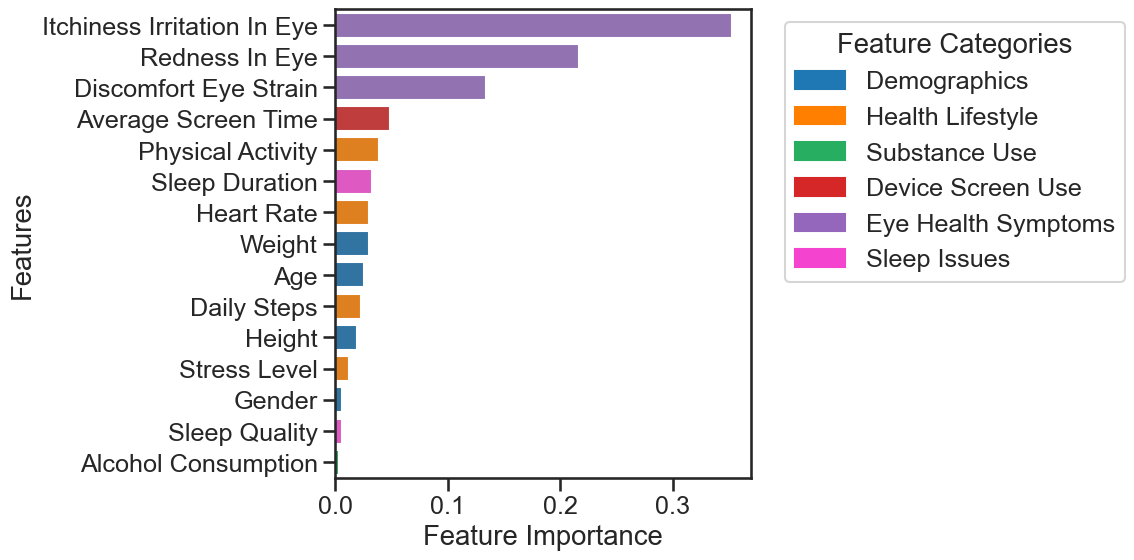

<Figure size 640x480 with 0 Axes>

In [102]:
feature_selection(df, 'dry_eye_disease', best_params=xgb_ded_full)

Best Parameters: {'colsample_bytree': 1.0, 'lambda': 9, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 49.43%, 39.94%
Accuracy: 50.58%, 60.06%
Precision: 50.55%, 60.07%
Recall: 50.58%, 60.06%
F1 Score: 50.55%, 60.04%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


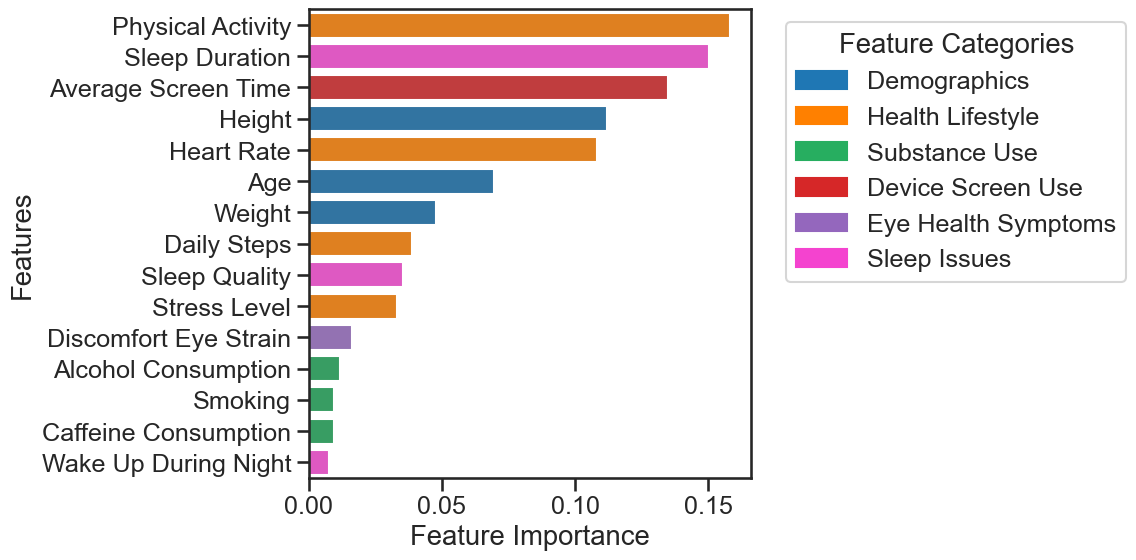

<Figure size 640x480 with 0 Axes>

In [103]:
feature_selection(df, 'sleep_disorder', best_params=xgb_insomnia_full)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error: 29.69%, 30.37%
Accuracy: 70.31%, 69.63%
Precision: 69.77%, 69.64%
Recall: 70.31%, 69.63%
F1 Score: 65.20%, 64.66%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


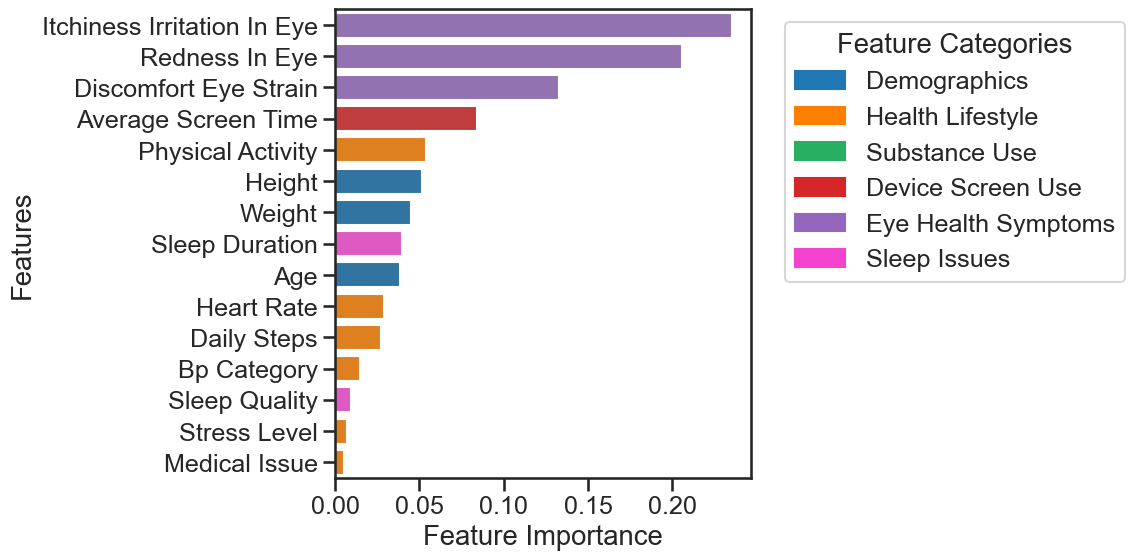

<Figure size 640x480 with 0 Axes>

In [104]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
feature_selection(df[df['age']<35], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 29.83%, 29.56%
Accuracy: 70.17%, 70.44%
Precision: 70.27%, 69.92%
Recall: 70.17%, 70.44%
F1 Score: 65.39%, 65.91%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


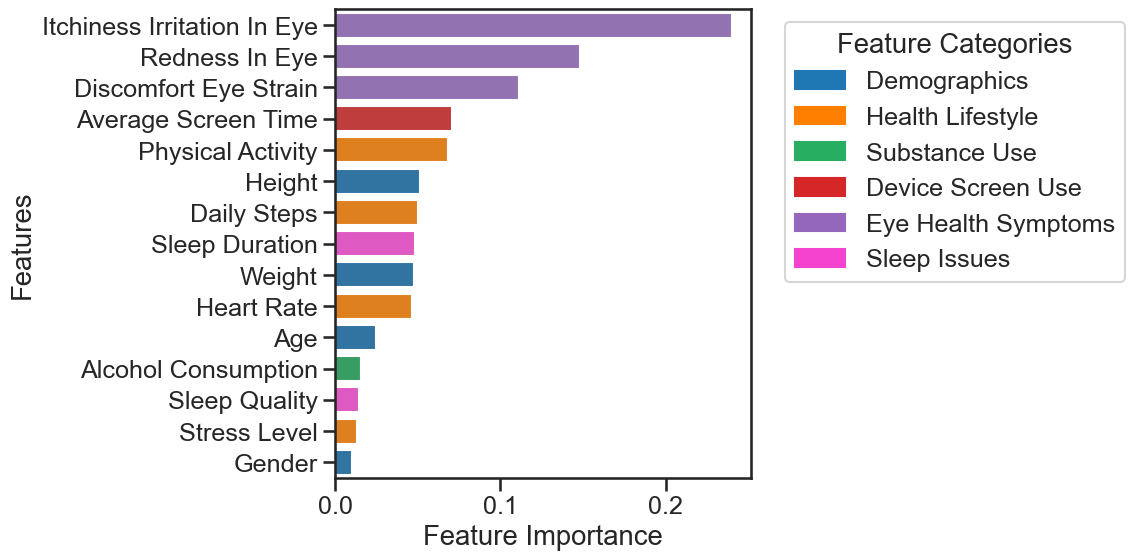

<Figure size 640x480 with 0 Axes>

In [105]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
feature_selection(df[df['age']>=35], 'dry_eye_disease', best_params=best_p)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 31.48%, 30.17%
Accuracy: 68.52%, 69.83%
Precision: 67.68%, 69.31%
Recall: 68.52%, 69.83%
F1 Score: 63.33%, 65.07%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


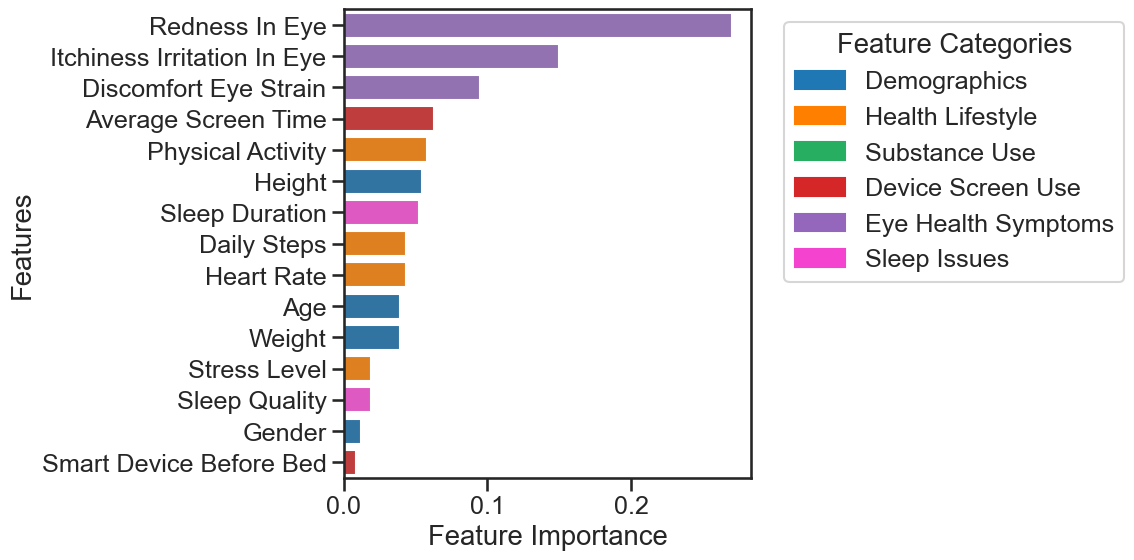

<Figure size 640x480 with 0 Axes>

In [106]:
best_p = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
feature_selection(df[df['physical_activity']<90], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 31.85%, 28.95%
Accuracy: 68.15%, 71.05%
Precision: 67.59%, 71.15%
Recall: 68.15%, 71.05%
F1 Score: 62.45%, 66.59%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


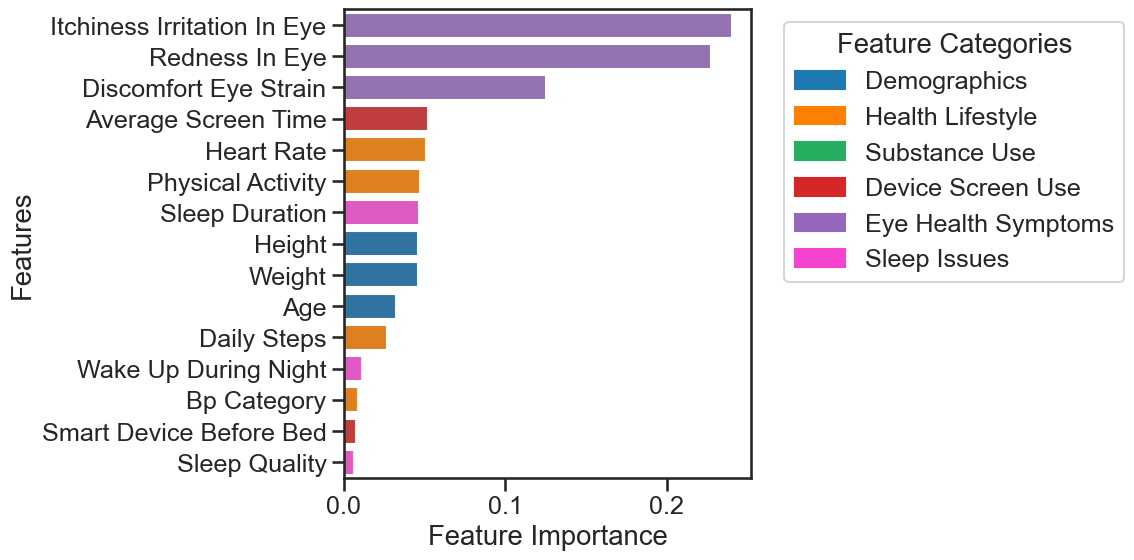

<Figure size 640x480 with 0 Axes>

In [107]:
best_p = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
feature_selection(df[df['physical_activity']>=90], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 31.70%, 29.87%
Accuracy: 68.30%, 70.13%
Precision: 69.11%, 70.11%
Recall: 68.30%, 70.13%
F1 Score: 63.70%, 65.40%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


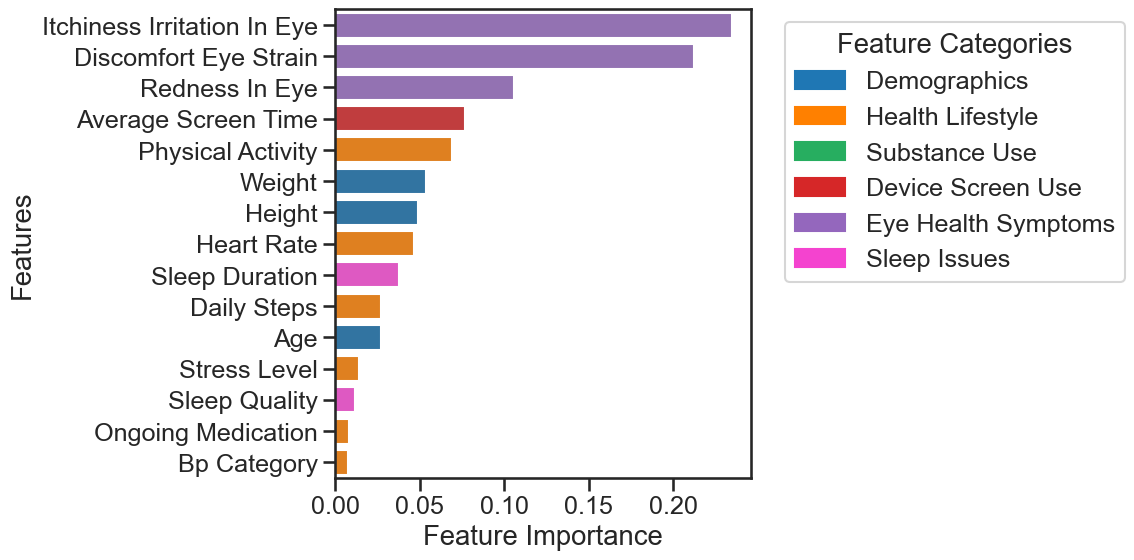

<Figure size 640x480 with 0 Axes>

In [111]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[df['gender']==1], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 30.23%, 29.30%
Accuracy: 69.77%, 70.70%
Precision: 69.13%, 70.22%
Recall: 69.77%, 70.70%
F1 Score: 64.94%, 65.90%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


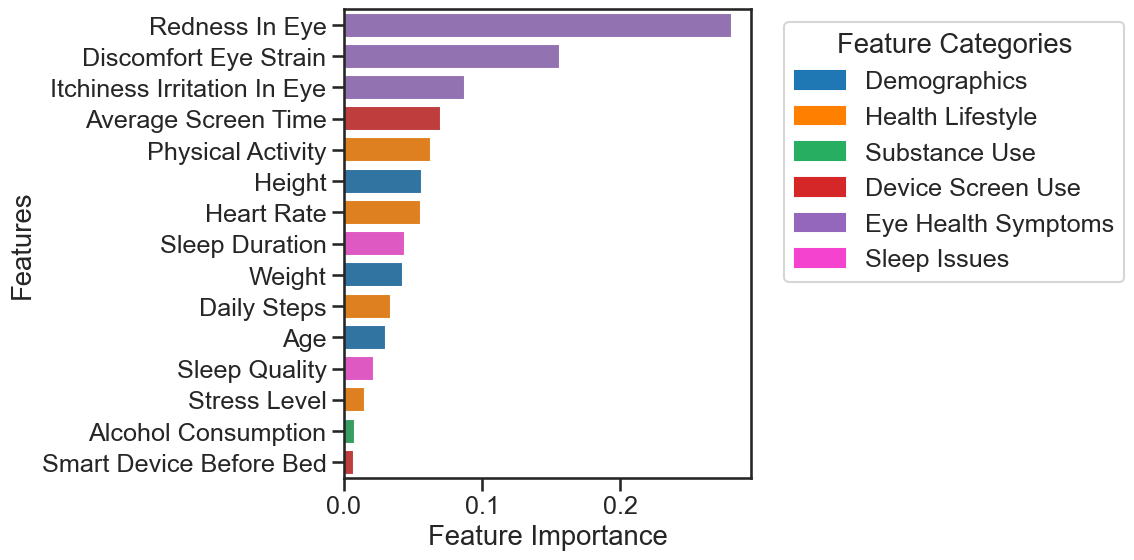

<Figure size 640x480 with 0 Axes>

In [108]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[df['gender']==0], 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 50.10%, 35.42%
Accuracy: 49.90%, 64.58%
Precision: 49.87%, 64.61%
Recall: 49.90%, 64.58%
F1 Score: 49.84%, 64.55%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


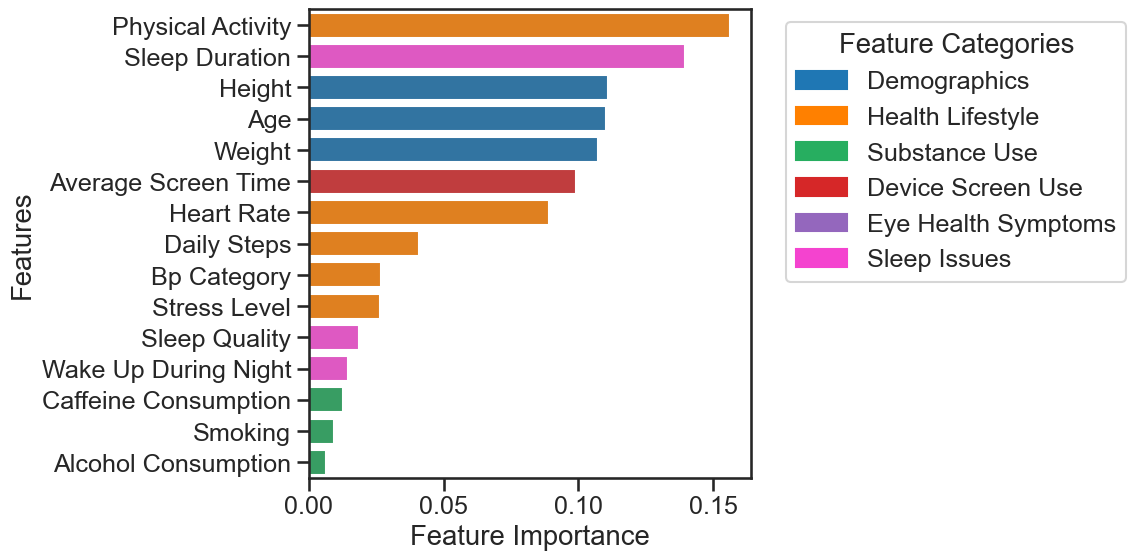

<Figure size 640x480 with 0 Axes>

In [109]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
feature_selection(df[df['gender']==1], 'sleep_disorder', best_params=best_p)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 48.97%, 36.03%
Accuracy: 51.03%, 63.97%
Precision: 51.06%, 63.98%
Recall: 51.03%, 63.97%
F1 Score: 51.03%, 63.97%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


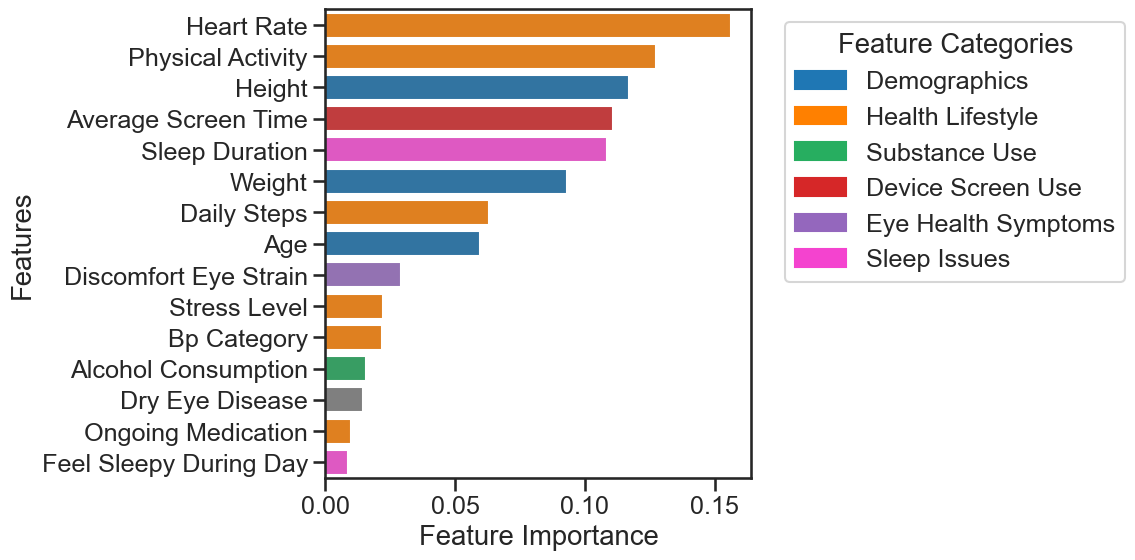

<Figure size 640x480 with 0 Axes>

In [110]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[df['gender']==0], 'sleep_disorder', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 48.79%, 36.14%
Accuracy: 51.21%, 63.86%
Precision: 51.22%, 63.87%
Recall: 51.21%, 63.86%
F1 Score: 51.16%, 63.79%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


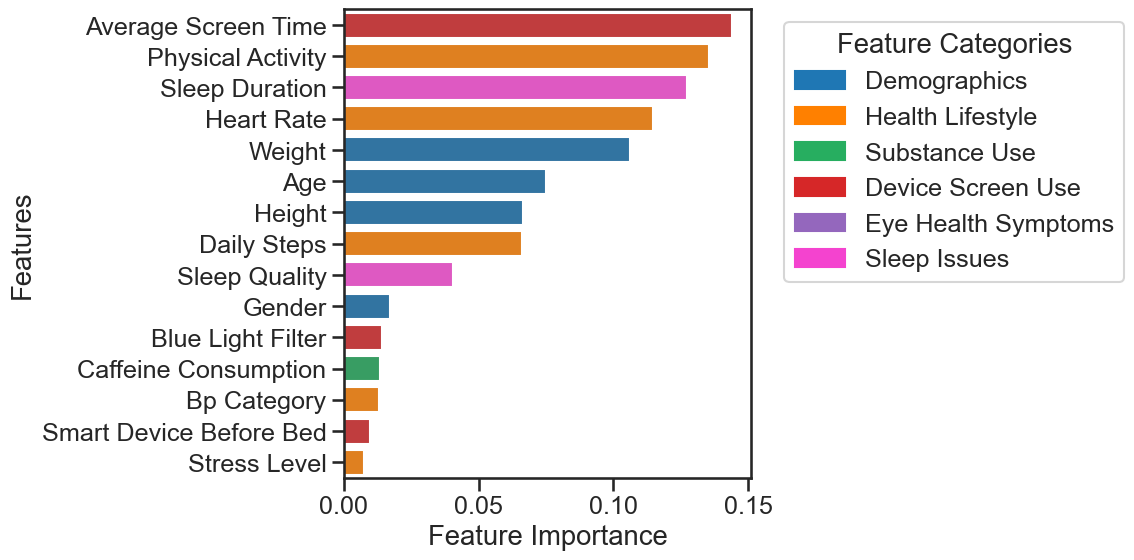

<Figure size 640x480 with 0 Axes>

In [112]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
feature_selection(df[df['age']<30], 'sleep_disorder', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Mean Squared Error: 50.72%, 35.77%
Accuracy: 49.28%, 64.23%
Precision: 49.18%, 64.28%
Recall: 49.28%, 64.23%
F1 Score: 49.13%, 64.15%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


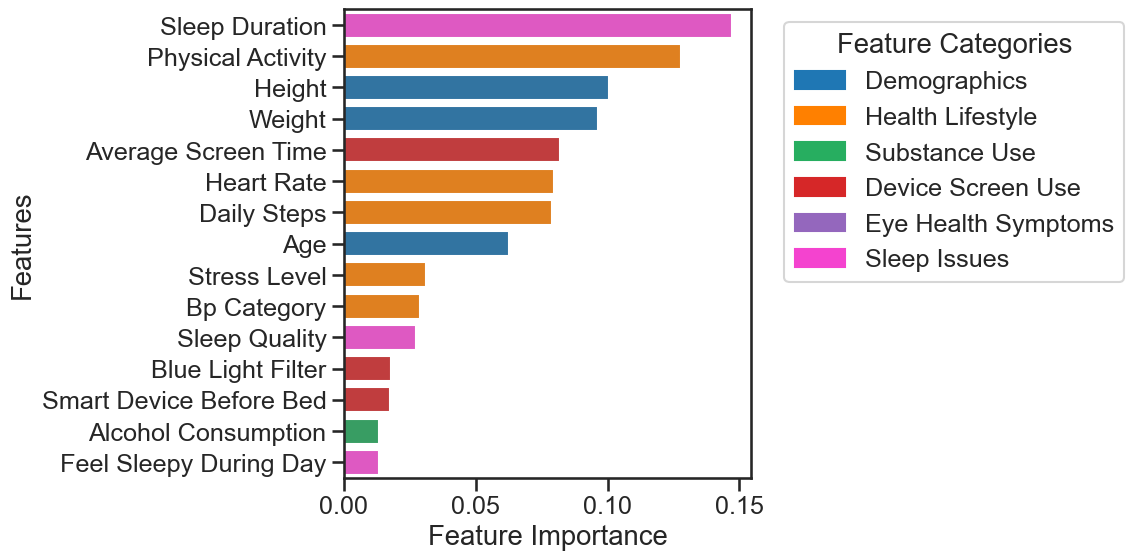

<Figure size 640x480 with 0 Axes>

In [114]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
feature_selection(df[(df['age']<=30)], 'sleep_disorder', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 32.67%, 35.27%
Accuracy: 67.33%, 64.72%
Precision: 61.68%, 67.09%
Recall: 67.33%, 64.72%
F1 Score: 54.27%, 51.03%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


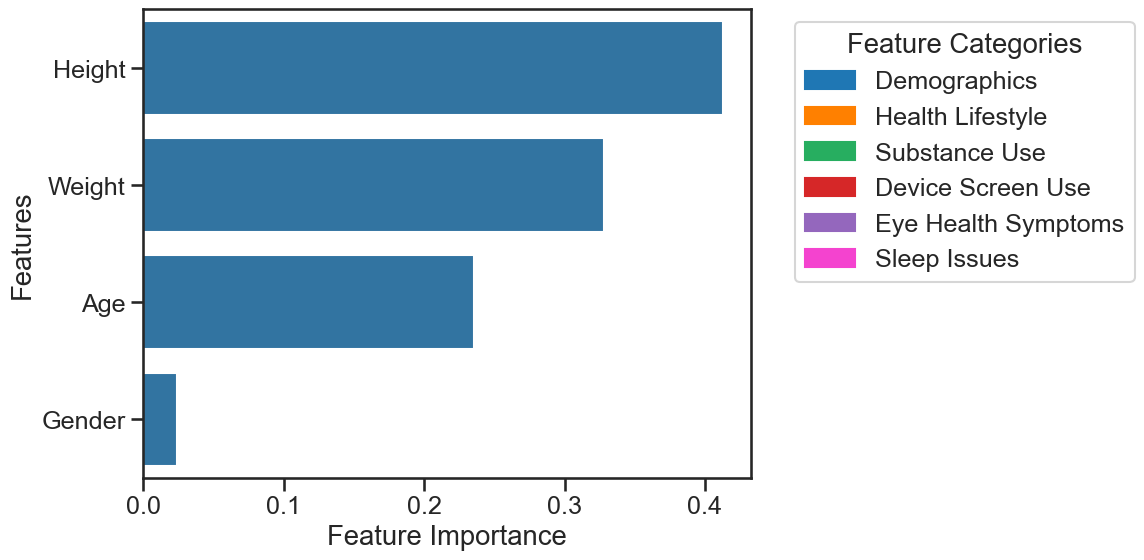

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 32.73%, 35.11%
Accuracy: 67.27%, 64.89%
Precision: 58.41%, 71.68%
Recall: 67.27%, 64.89%
F1 Score: 54.34%, 51.43%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

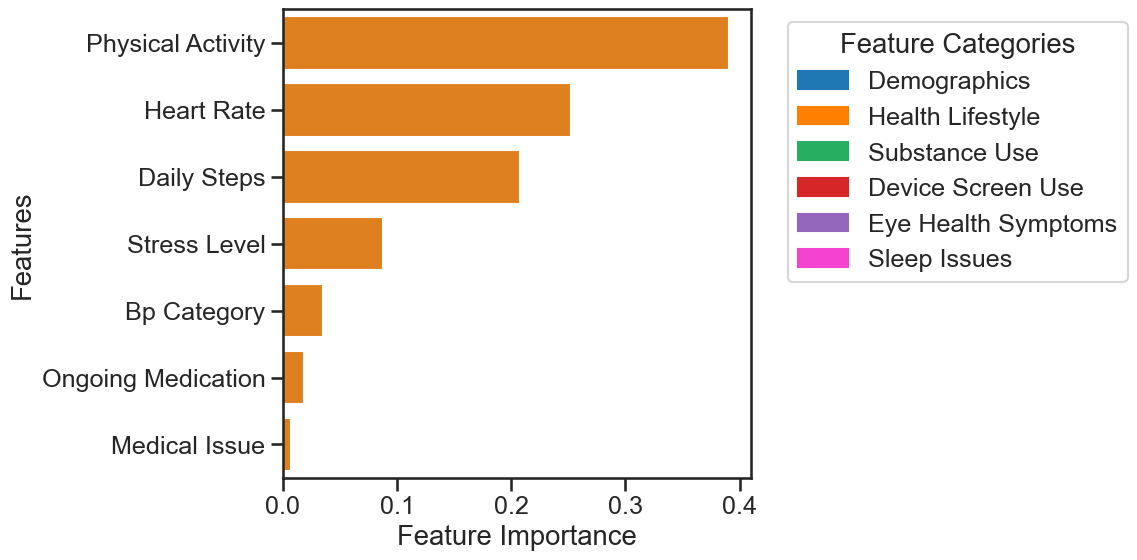

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 32.67%, 35.35%
Accuracy: 67.33%, 64.65%
Precision: 45.33%, 41.80%
Recall: 67.33%, 64.65%
F1 Score: 54.18%, 50.77%
------------------------------


/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

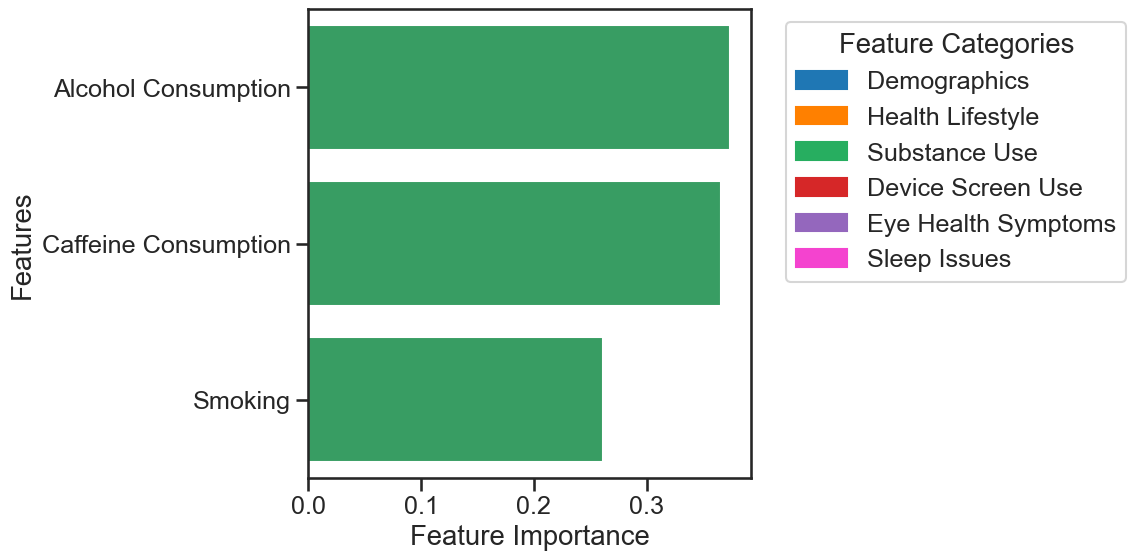

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 32.67%, 35.35%
Accuracy: 67.33%, 64.65%
Precision: 45.33%, 41.80%
Recall: 67.33%, 64.65%
F1 Score: 54.18%, 50.77%
------------------------------


/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

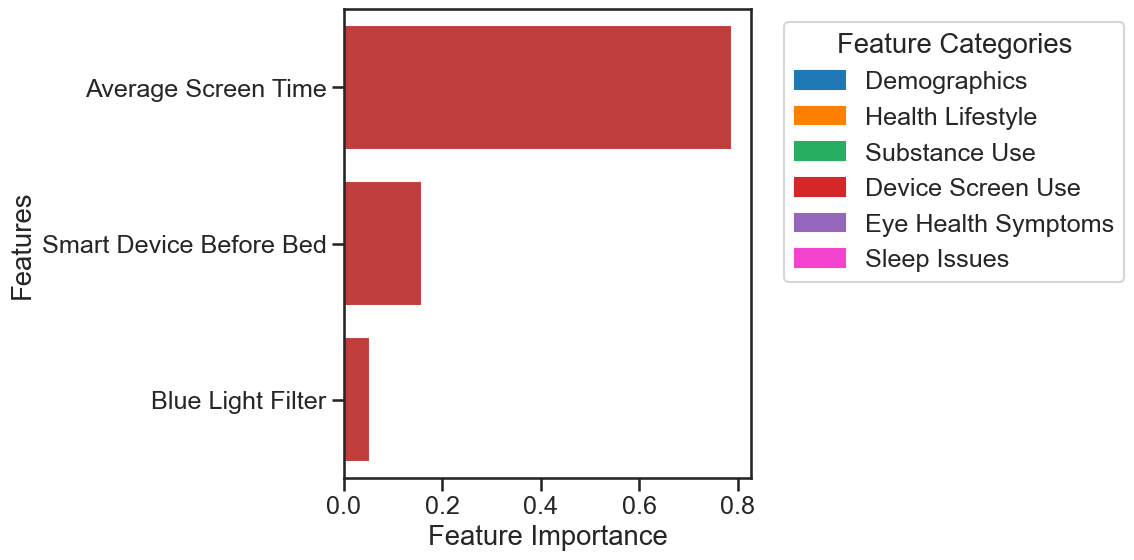

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 29.83%, 30.29%
Accuracy: 70.17%, 69.71%
Precision: 68.26%, 69.69%
Recall: 70.17%, 69.71%
F1 Score: 65.18%, 64.91%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

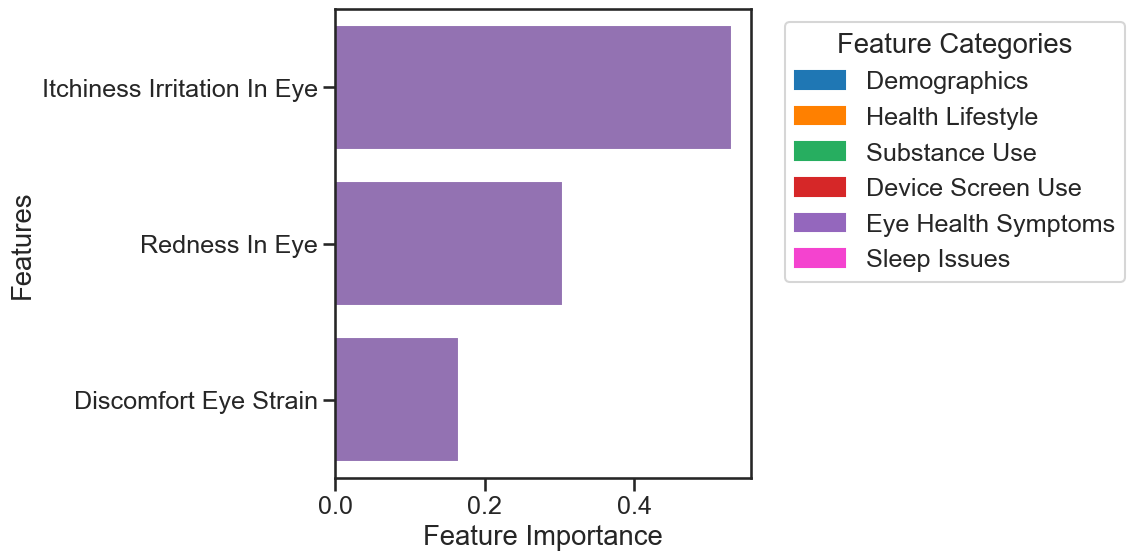

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 32.67%, 35.33%
Accuracy: 67.33%, 64.68%
Precision: 61.67%, 63.42%
Recall: 67.33%, 64.68%
F1 Score: 54.22%, 50.91%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

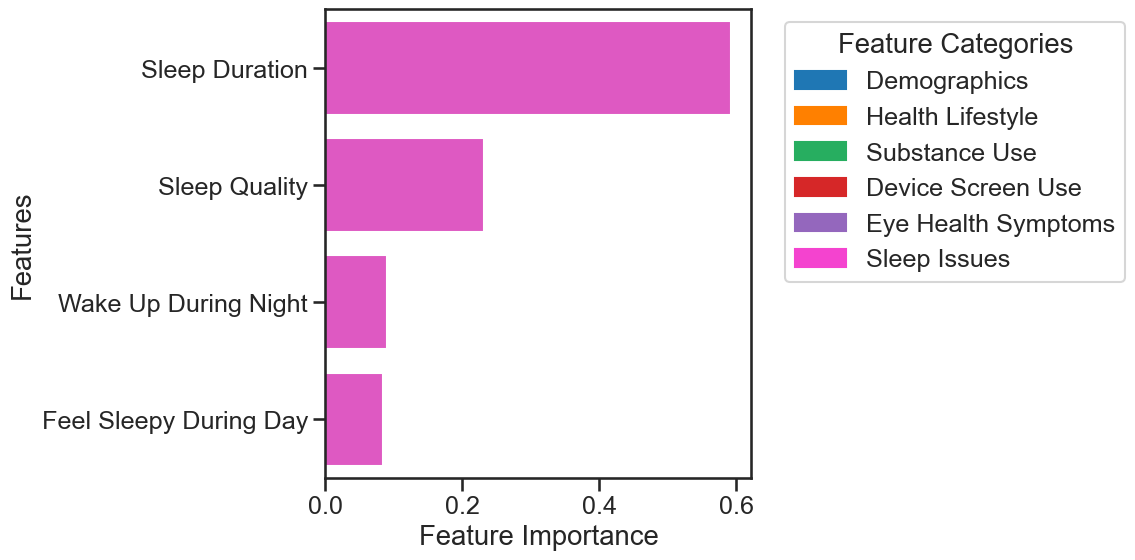

<Figure size 640x480 with 0 Axes>

In [115]:
for cat in category_map:
    ll = category_map[cat].copy()
    ll.extend(list(["dry_eye_disease"]))
    df1 = df[ll]
    best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
    feature_selection(df1, 'dry_eye_disease', best_params=best_p)

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 50.38%, 44.48%
Accuracy: 49.62%, 55.52%
Precision: 49.57%, 55.53%
Recall: 49.62%, 55.52%
F1 Score: 49.53%, 55.44%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


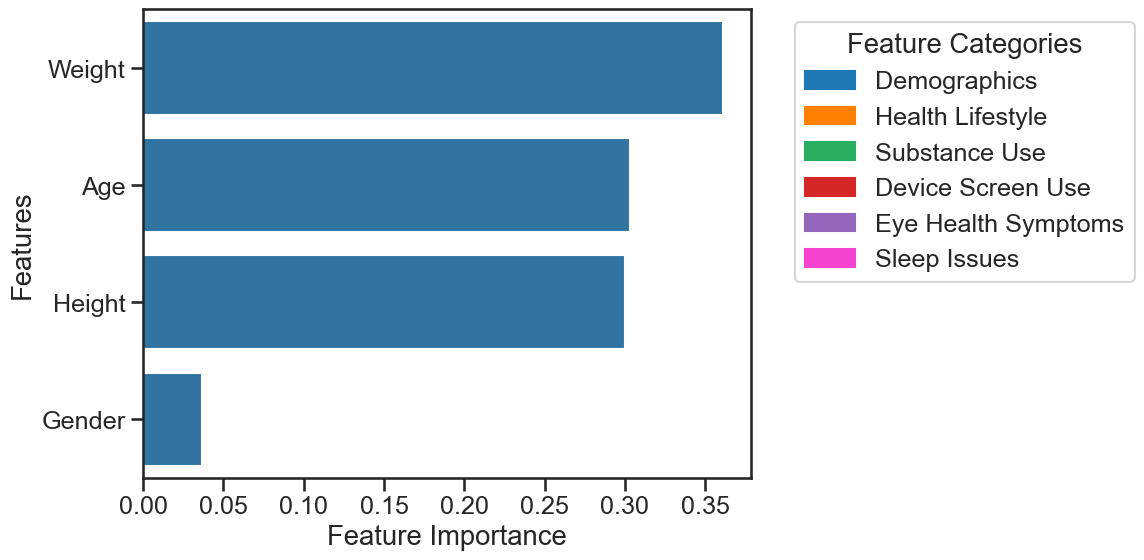

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 50.18%, 43.44%
Accuracy: 49.83%, 56.56%
Precision: 49.83%, 56.56%
Recall: 49.83%, 56.56%
F1 Score: 49.83%, 56.55%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

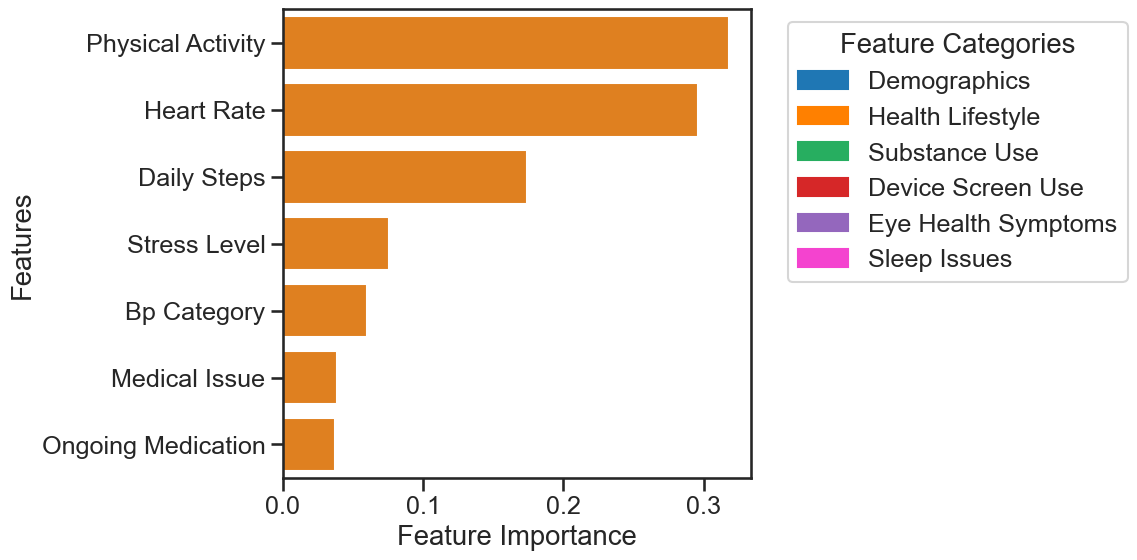

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 49.40%, 49.32%
Accuracy: 50.60%, 50.68%
Precision: 50.39%, 50.72%
Recall: 50.60%, 50.68%
F1 Score: 47.26%, 47.50%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

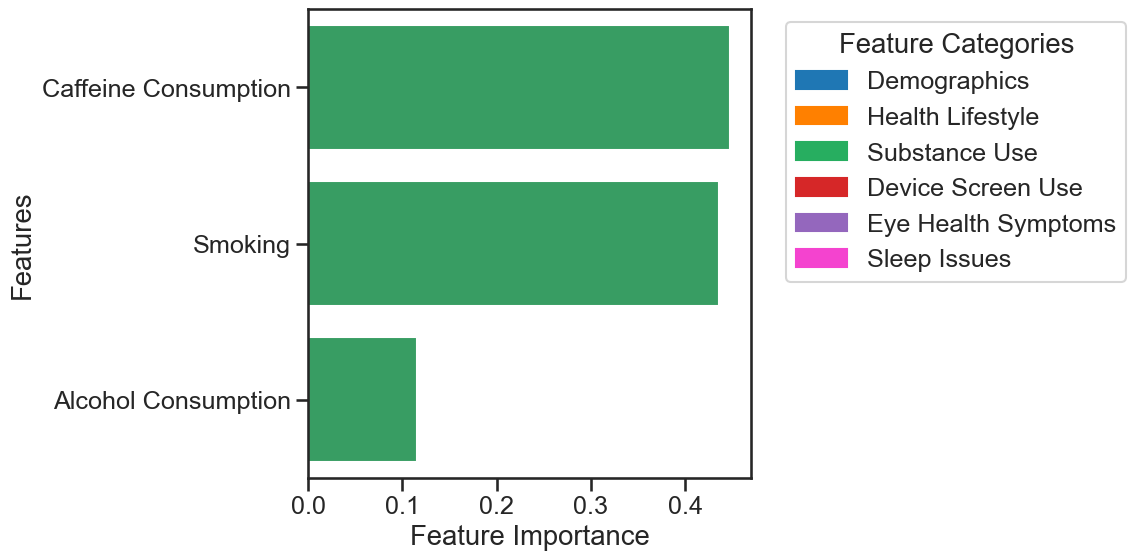

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 49.90%, 46.76%
Accuracy: 50.10%, 53.24%
Precision: 50.03%, 53.25%
Recall: 50.10%, 53.24%
F1 Score: 49.90%, 53.12%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

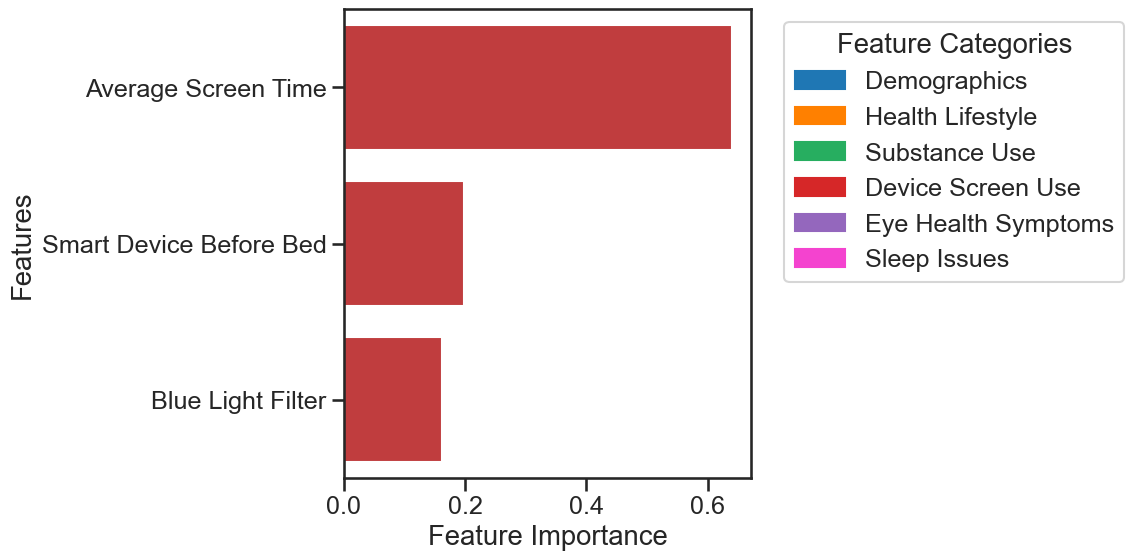

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 49.62%, 48.91%
Accuracy: 50.38%, 51.09%
Precision: 49.81%, 51.97%
Recall: 50.38%, 51.09%
F1 Score: 42.41%, 43.27%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

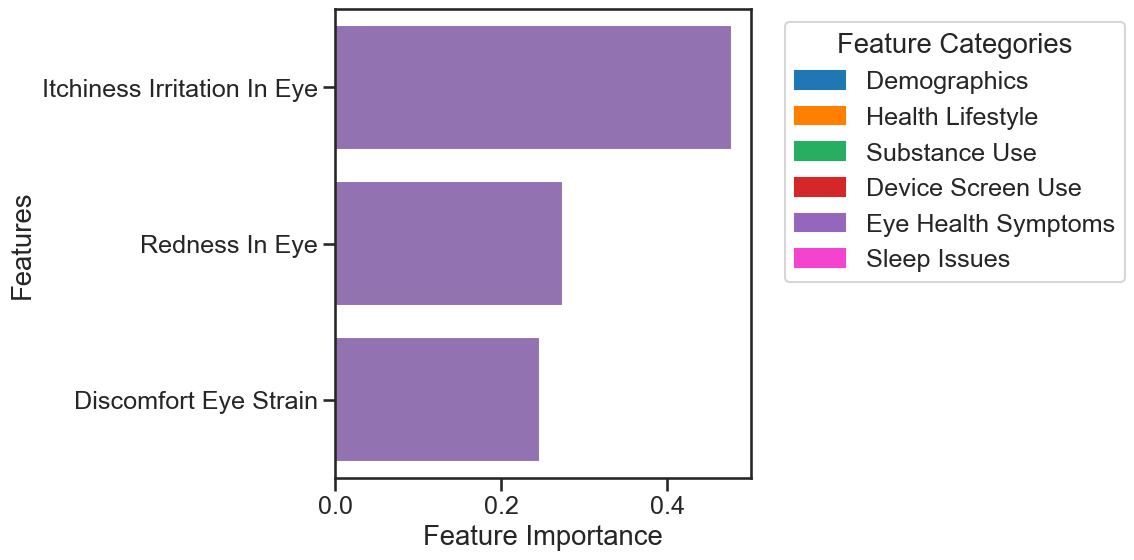

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 49.33%, 46.17%
Accuracy: 50.68%, 53.83%
Precision: 50.64%, 53.83%
Recall: 50.68%, 53.83%
F1 Score: 50.60%, 53.78%
------------------------------


/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_79327/108877727.py:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<Figure size 640x480 with 0 Axes>

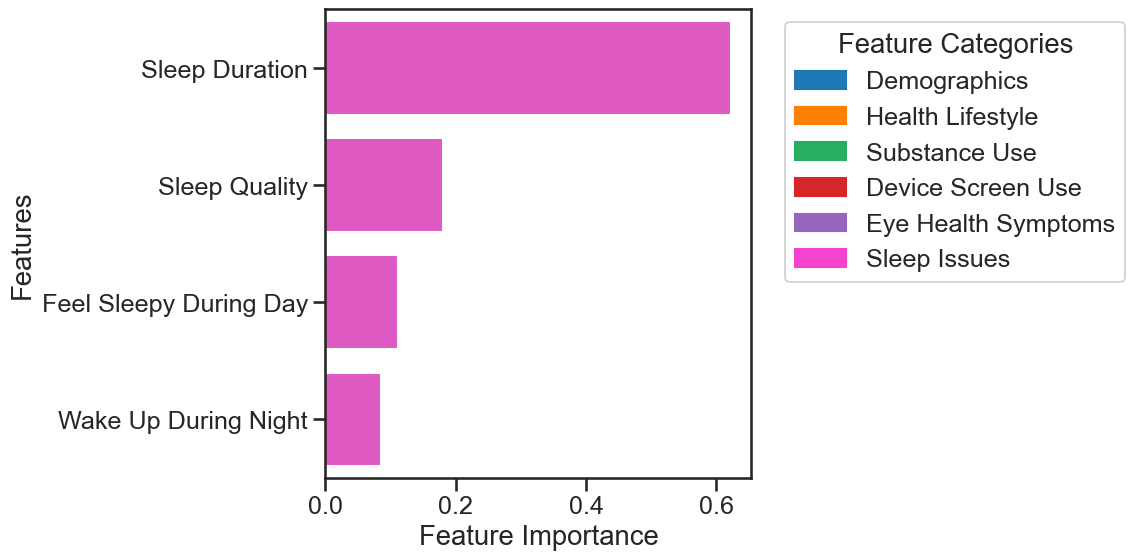

<Figure size 640x480 with 0 Axes>

In [116]:
for cat in category_map:
    ll = category_map[cat].copy()
    ll.extend(list(["sleep_disorder"]))
    df1 = df[ll]
    best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
    feature_selection(df1, 'sleep_disorder', best_params=best_p)